<a href="https://colab.research.google.com/github/timwinter06/internship/blob/master/Brute_force_hyper_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras import utils
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM

import scipy.io as sio
import os
import random

from itertools import product
from collections import namedtuple

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Define functions

def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    return a, b

def feature_normalize(dataset, label):
    
    mu = np.mean(dataset, axis=1)
    sigma = np.std(dataset, axis=1)
    
    if np.any(sigma == 0):
        print('There are sigmas = 0, these are removed.')
        
    # Find where sigmas are zero and remove those trials
    ind = np.where(sigma == 0)
    dataset = np.delete(dataset,ind,0)
    label = np.delete(label,ind,0)
    sigma = np.delete(sigma,ind,0)
    mu = np.delete(mu,ind,0)
    normal = np.transpose((np.transpose(dataset) - mu)/sigma)
    
    return normal, label, ind

def import_data(animal, direct): # select animal (as string) to import data from
    # Import all the data in the Processed data file
    directory = direct + animal
    fnames = os.listdir(directory)
    whisk_data = {}
    nr_files = len(fnames)
    for i in range (0, nr_files):
        fname = directory + '//' + fnames[i]
        whisk_data[i] = sio.loadmat(fname)
    return (whisk_data)

def pre_process(whisk_data, no_zero, corr):
    nr_files = len(whisk_data.keys())
    shapes = np.zeros((2,nr_files))
    for i in range (0,nr_files):
        shapes[:,i] = whisk_data[i]['xtrain'].shape
    # Pad the whisking traces to ensure they are all the same length
    length = int(np.min(shapes[1,:]))
    whisk = {}  
    for i in range (0,nr_files):
        whisk_2 = np.zeros((whisk_data[i]['xtrain'].shape[0], length))
        whisk_2[:,0:int(length/2)] = whisk_data[i]['xtrain'][:,0:int(length/2)]
        whisk_2[:,int(length/2)+1:] = whisk_data[i]['xtrain'][:,whisk_data[i]['xtrain'].shape[1]-int(length/2)+1:]
        whisk[i] = whisk_2
    
    # Let's create one array with all of the training data 
    x_whisk = whisk[0]
    y_whisk = whisk_data[0]['ytrain']

    for i in range (1,nr_files):
        x_whisk = np.concatenate((x_whisk , whisk[i]), axis =0)
        y_whisk = np.concatenate((y_whisk , whisk_data[i]['ytrain']), axis =0)
        
    correct = whisk_data[0]['correct']
    for i in range (1,nr_files):
        correct = np.concatenate((correct,whisk_data[i]['correct']),axis = 0)
            
    if no_zero == 1:
        # Delete rows of array with no pole location (pole location = 0)
        zero = np.where(y_whisk[:,1] == 0)
        x_whisk = np.delete(x_whisk,zero,0)
        y_whisk = np.delete(y_whisk,zero,0)  
        correct = np.delete(correct,zero,0)
    if corr == 1:
        # Only take correct data
        ind = np.where(correct == 1)
        x_whisk = x_whisk[ind[0],:]
        y_whisk = y_whisk[ind[0],:]
        
    x_whisk, y_whisk = shuffle_in_unison(x_whisk, y_whisk)
    # Split data into train and test data, roughly 80-20
    split = round(0.8*x_whisk.shape[0])
    xtrain = x_whisk[0:split,:]
    xtest = x_whisk[split + 1:,:]
    ytrain = y_whisk[0:split,0]
    ytest = y_whisk[split + 1:,0]
    xtrain = xtrain.astype("float32")
    ytrain = ytrain.astype("float32")
    xtest = xtest.astype("float32")
    ytest = ytest.astype("float32")
    length_2_trial = xtrain.shape[1]
    length_trial = int(length_2_trial/2)
    x_train_angle = xtrain[:, length_trial:length_2_trial ]
    x_train_curve = xtrain[:, 0:length_trial ]
    x_test_angle = xtest[:, length_trial:length_2_trial ]
    x_test_curve = xtest[:, 0:length_trial ]
    # And normalise the data
    x_train_curve, ytrain, ind_1 = feature_normalize(x_train_curve, ytrain)
    x_train_angle = np.delete(x_train_angle,ind_1[0],0)
    x_train_angle, ytrain, ind_2 = feature_normalize(x_train_angle, ytrain)
    x_train_curve = np.delete(x_train_curve,ind_2[0],0)
    x_test_curve, ytest, ind_3 = feature_normalize(x_test_curve, ytest)
    x_test_angle = np.delete(x_test_angle,ind_3[0],0)
    x_test_angle, ytest, ind_4 = feature_normalize(x_test_angle, ytest)
    x_test_curve = np.delete(x_test_curve,ind_4[0],0)
    # concatenate all data
    x_train_all = np.concatenate((x_train_curve, x_train_angle), axis = 1)
    x_test_all = np.concatenate((x_test_curve, x_test_curve), axis = 1)
    for i in range (0,ytrain.shape[0]):
        if ytrain[i] == -1:
            ytrain[i] = 0
    for i in range (0,ytest.shape[0]):
        if ytest[i] == -1:
            ytest[i] = 0
    num_classes = 2
    ytrain = utils.to_categorical(ytrain, num_classes)
    ytest = utils.to_categorical(ytest, num_classes)
    return (x_train_all, x_test_all, ytrain, ytest, x_train_curve, x_train_angle, x_test_curve, x_test_angle)

def plot_some(x_t_c, x_t_a, ytrain, number, save, name, rnd ):
    # Lets plot random proximal trials and 10 random distal trials
    prox = np.where(ytrain == [1, 0])
    dist = np.where(ytrain == [0, 1])
    width = 0.5
    mark = 0.5
    ymin = -20
    ymax = 20

    prox = np.ndarray.tolist(prox[0])
    dist = np.ndarray.tolist(dist[0])

    fig = plt.figure( figsize = (18,9))

    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)
    
    if rnd == 1:
      rnd_p = random.sample(prox, number)
      rnd_d = random.sample(dist, number)
    elif rnd == 0:
      rnd_p = prox
      rnd_d = dist
 
    x_train_curve = x_t_c
    x_train_angle = x_t_a

    for n in range (0, len(rnd_p)):
        # Plot proximal
        ax1.plot(x_train_curve[rnd_p[n],:],'b',linewidth = width, markersize = mark) # plot curve
        ax1.set_title('Proximal curvature')
        ax1.set_ylim([ymin,ymax])
        ax1.set_xlabel('time/ms')
        ax2.plot(x_train_angle[rnd_p[n],:],'b',linewidth = width,markersize = mark) # plot angle
        ax2.set_title('Proximal angle')
        ax2.set_ylim([ymin,ymax])
        ax2.set_xlabel('time/ms')
    for n in range (0, len(rnd_d)):
        # Plot distal
        ax3.plot(x_train_curve[rnd_d[n],:],'r',linewidth = width,markersize = mark) # plot curve
        ax3.set_title('Distal curvature')
        ax3.set_ylim([ymin,ymax])
        ax3.set_xlabel('time/ms')
        ax4.plot(x_train_angle[rnd_d[n],:],'r',linewidth = width,markersize = mark) # plot angle
        ax4.set_title('Distal angle')
        ax4.set_ylim([ymin,ymax])
        ax4.set_xlabel('time/ms')
    if save == 1:
      fig.savefig(name)
    return()

def get_runs(params):
  Run = namedtuple('Run', params.keys())
  runs = []
  for v in product(*params.values()):
      runs.append(Run(*v))
  return runs

  # Make function that runs the test function a few times and then returns the average of the accuracy.

# Pass functions, data, and the number of trainings you want to average over

def find_average_metrics(find_hyper, find_hyper_LSTM, data, number, LongShort): # Set LSTM to 0 to train CNN, set it to 1 to train LSTM-CNN
  
  # Define dictionary to store performance in
  history = {}
  score = {}

  # Make loop where each time the performance of the network is calculated
  
  for n in range (number):
    print('Run of training: ' + str(n))

    # Make network for all parameter combinations and train and test it
    if LongShort == 0:
      all_history, all_score, model = find_hyper(data['xtrain'], data['xtest'], data['ytrain'], data['ytest'], data['hyper'])
    if LongShort == 1:
      all_history, all_score, model = find_hyper_LSTM(data['x_train_curve'], data['x_train_angle'], data['x_test_curve'], data['x_test_angle'], data['ytrain'], data['ytest'], data['hyper'])
    # Now save the taining and testing performance for this run

    history[n] = all_history
    score[n] = all_score

  return(history, score)

  # Calculate average of the trials
def get_average (history, score):
  metrics = {}
  metrics['val_acc'] = np.zeros((len(history), len(history[0])))
  metrics['test_acc'] = np.zeros((len(history), len(history[0])))
  metrics['val_loss'] = np.zeros((len(history), len(history[0])))
  metrics['test_loss'] = np.zeros((len(history), len(history[0])))

  # Get the val and test acc for each combination for each run

  for i in range (len(history)):
    for t in range (len(history[0])):
      metrics['val_acc'][ i, t] = history[i][t]['val_accuracy'][-1]    # Validation accuracy
      metrics['test_acc'][ i, t] = score[i][t][1]                  # Test accuracy
      metrics['test_loss'][ i, t] = score[i][t][0]                # Test loss
      metrics['val_loss'][i,t] = history[i][t]['val_loss'][-1]    # Validation loss 

  metrics['av_val_acc'] = np.zeros(len(history[0]))
  metrics['av_test_acc'] = np.zeros(len(history[0]))
  metrics['av_val_loss'] = np.zeros(len(history[0]))
  metrics['av_test_loss'] = np.zeros(len(history[0]))

  # Calculate mean
  metrics['av_val_acc'] = np.mean(metrics['val_acc'], axis = 0)
  metrics['av_test_acc'] = np.mean(metrics['test_acc'], axis = 0)
  metrics['av_val_loss'] = np.mean(metrics['val_loss'], axis = 0)
  metrics['av_test_loss'] = np.mean(metrics['test_loss'], axis = 0)

  return( metrics)

# Brute force function to find best hyperparameters for lSTM-CNN 

def find_hyper_LSTM(x_train_curve, x_train_angle, x_test_curve, x_test_angle, ytrain, ytest, hyper):

    # Change the y labels to 1D 1s or 0s.

    ytr = np.zeros(len(ytrain))
    yte = np.zeros(len(ytest))
    for i in range (0,len(ytrain)):
      if np.all(ytrain[i,:] == [1, 0]):
        ytr[i] = 1
    for i in range (0,len(ytest)):
      if np.all(ytest[i,:] == [1, 0]):
        yte[i] = 1

    ytrain = ytr
    ytest = yte

    TIME_PERIODS = x_train_curve.shape[1]
    num_features = 2
    number_samples = x_train_curve.shape[0]
    number_test = x_test_curve.shape[0]

    # Create the correct input arrays for the LSTM network

    x_train = np.zeros((number_samples, TIME_PERIODS, num_features))
    x_test = np.zeros((number_test, TIME_PERIODS, num_features))

    x_train[:,:,0] = x_train_angle
    x_train[:,:,1] = x_train_curve
    x_test[:,:,0] = x_test_angle
    x_test[:,:,1] = x_test_curve

    # First define the dictionaires which return the test accuracy and loss, 
    # train accuracy and loss, and validate accuracy and loss.
    
    all_score = {} 
    all_history = {}
    
    # Define some basic parameters
    EPOCHS = 10
    
    # Now loop over the combinations of hyperparameters, each time creating a neural network, 
    # training it, and testing it. The test validation is then saved for each iteration.
        
    # MAIN LOOP
    
    for i in range (len(runs)):
        print('Training network '+ str(i) )
    # Build the CNN / LSTM 
        model_m = Sequential()
    # Build a first convolutional layer
        model_m.add(Conv1D(runs[i].Filter_number, runs[i].Filter_size_1, activation='relu', input_shape=(TIME_PERIODS,num_features)))
    # Add a second convolutional layer
        if runs[i].layers == 2 or runs[i].layers == 3:
          model_m.add(MaxPooling1D(runs[i].Pooling_1))
          model_m.add(Conv1D(runs[i].Filter_number, runs[i].Filter_size_2, activation='relu'))
    # Add a third convolutional layer
        if runs[i].layers == 3:
          model_m.add(MaxPooling1D(runs[i].Pooling_2))
          model_m.add(Conv1D(runs[i].Filter_number, runs[i].Filter_size_3, activation='relu'))
    # Add an LSTM layer
        model_m.add(MaxPooling1D(runs[i].Pooling_3))
        model_m.add(LSTM(runs[i].LongShort))
        model_m.add(Dense(1, activation='sigmoid'))

        callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)]
                                                          
        model_m.compile(loss='binary_crossentropy',
                            optimizer='adam', metrics=['accuracy'])
    
        history = model_m.fit(x_train,ytrain,
                              batch_size = runs[i].Batch_size,
                              epochs=EPOCHS,
                              callbacks=callbacks_list,
                              validation_split=0.2,verbose=0)
                              
        score = model_m.evaluate(x_test, ytest, verbose=0)
        
        # Save the performance of the network in two dictionaries
        
        all_history[i] = history.history
        all_score[i] = score
           
    return(all_history, all_score, model_m)

# Brute force function to find best hyperparameters for 1D-CNN 

# Run a function/ loop that varies the hyperparameters and returns the accuracy and loss for each combinations of hyperparameters

def find_hyper(xtrain, xtest, ytrain, ytest, hyper):
    
    # First define the dictionaires which return the test accuracy and loss, 
    # train accuracy and loss, and validate accuracy and loss.
    
    all_score = {} 
    all_history = {}
    
    # Define some basic parameters
    
    TIME_PERIODS = int(xtrain.shape[1]/2)
    input_shape = xtrain.shape[1]
    num_sensors = 2
    num_classes = 2 
    EPOCHS = 10
    
    # Now loop over the combinations of hyperparameters, each time creating a neural network, 
    # training it, and testing it. The test validation is then saved for each iteration.
        
    # MAIN LOOP
    
    for i in range (len(runs)):
        print('Training network '+ str(i) )
    # Build the CNN

    # Add first layer
        model_m = Sequential()
        model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
        model_m.add(Conv1D(runs[i].Filter_number, runs[i].Filter_size_1, activation='relu', input_shape=(TIME_PERIODS,num_sensors)))
    # Add second layer    
        if runs[i].layers == 2 or runs[i].layers == 3 or runs[i].layers == 4:
          model_m.add(MaxPooling1D(runs[i].Pooling_1))
          model_m.add(Conv1D(runs[i].Filter_number, runs[i].Filter_size_2, activation='relu'))
    # Add third layer
        if runs[i].layers == 3 or runs[i].layers == 4:
          model_m.add(MaxPooling1D(runs[i].Pooling_2))
          model_m.add(Conv1D(runs[i].Filter_number, runs[i].Filter_size_3, activation='relu'))
    # Add fourth layer
        if runs[i].layers == 4:
          model_m.add(MaxPooling1D(runs[i].Pooling_3))
          model_m.add(Conv1D(runs[i].Filter_number, runs[i].Filter_size_4, activation='relu'))
    # Poolng, droput and output  
        model_m.add(GlobalAveragePooling1D())
        model_m.add(Dropout(0.5))
        model_m.add(Dense(num_classes, activation='softmax'))

    # End of CNN
        callbacks_list = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)]
    # Train CNN                                                     
        model_m.compile(loss='binary_crossentropy',
                            optimizer='adam', metrics=['accuracy'])
    
        history = model_m.fit(xtrain,ytrain,
                              batch_size = runs[i].Batch_size,
                              epochs=EPOCHS,
                              callbacks=callbacks_list,
                              validation_split=0.2,verbose=0)
    # Test CNN                         
        score = model_m.evaluate(xtest, ytest, verbose=0)
        
    # Save the performance of the network in two dictionaries
        all_history[i] = history.history
        all_score[i] = score
           
    return(all_history, all_score, model_m)

# Write function that predicts target labels with model and find out if those are correct or not. 
# Find out which trials are not correctly predicted.  

def prediction(model, y_test, x_test, CNN):

  # Find out the predictions of the model
  y_pred_test = model.predict(x_test)

  if CNN == 1:
    y_pred_label = np.zeros((len(y_test),2))
  # Change to 1s and 0s
    for i in range (len(y_test)):
      if y_pred_test[i,0] > y_pred_test[i,1]:
        y_pred_label[i,:] = [1, 0]
      else:
        y_pred_label[i,:] = [0, 1]
  elif CNN == 0:
    y_pred_label = np.zeros((len(y_test),1))
    yte = np.zeros(len(y_test))
    for i in range (0,len(y_test)):
      if np.all(ytest[i,:] == [1, 0]):
        yte[i] = 1
    y_test = yte
    # Changes to 1s and 0s
    for i in range (len(y_test)):
      if y_pred_test[i] > 0.5:
        y_pred_label[i] = 1

  # Make empty list in which to store trial numbers which are misclassified and another for correctly classified trials
  y_incorrect = []
  y_correct = []

  # Loop over all trials to check if they are classifed correctly
  for i in range (len(y_test)):
    if CNN == 1:
      if np.all(y_pred_label[i,:] != y_test[i,:]):
      # Store the 'incorrect' trials
        y_incorrect = np.append(y_incorrect,i)
      else:
        y_correct = np.append(y_correct,i)
    elif CNN == 0:
      if y_pred_label[i] != y_test[i]:
        y_incorrect = np.append(y_incorrect,i)
      else:
        y_correct = np.append(y_correct, i)

  # Change float array to int array
  y_incorrect = y_incorrect.astype(int)
  y_correct = y_correct.astype(int)

  # Calculate accuracy
  acc = 1 - (len(y_incorrect)/len(y_test))

  return(acc, y_correct, y_incorrect, y_pred_test, y_pred_label)

  # Calculate the variance for correctly classified trials and the incorrectly classified trials. 

def variance(x_angle, x_curve, y):

  prox = np.where(y == [1, 0])
  dist = np.where(y == [0, 1])
  prox = np.unique(prox[0])
  dist = np.unique(dist[0])
  var_prox_angle = np.var(x_angle[prox], axis=1)
  var_prox_curve = np.var(x_curve[prox], axis=1)
  var_dist_angle = np.var(x_angle[dist], axis=1)
  var_dist_curve = np.var(x_curve[dist], axis=1)

  return(var_prox_angle, var_prox_curve, var_dist_angle, var_dist_curve)

def gradient(x_angle, x_curve, y):

  # Return the gradient array for a whisking trace

  prox = np.where(y == [1, 0])
  dist = np.where(y == [0, 1])
  prox = np.unique(prox[0])
  dist = np.unique(dist[0])
  grad = {}
  grad['prox_angle'] = np.gradient(x_angle[prox], axis=1)
  grad['prox_curve'] = np.gradient(x_curve[prox], axis=1)
  grad['dist_angle'] = np.gradient(x_angle[dist], axis=1)
  grad['dist_curve'] = np.gradient(x_curve[dist], axis=1)

  return(grad)

In [ ]:
# Import all the data and preprocess
whisk_data = import_data('an171923','/content/drive/My Drive/Processed data//')
# Choose if you want data with no pole location and if you want correct trials
no_zero , corr = 1 , 1
xtrain, xtest, ytrain, ytest, x_t_c, x_t_a, x_test_c, x_test_a = pre_process(whisk_data, no_zero, corr)
# Plot a number of the trials
#number = 100
#plot_some(x_t_c, x_t_a, ytrain, number)


There are sigmas = 0, these are removed.


In [ ]:
# Define a dictionary with all the hyperparameters you want to test in the lSTM_CNN

hyper_lstm = { 'Batch_size': [32]
              ,'Filter_number': [200]
              ,'Filter_size_1': [10]
              ,'Pooling_1': [3]
              ,'Filter_size_2':[10]
              ,'Pooling_2':[3]
              ,'Filter_size_3':[10]
              ,'Pooling_3':[ 3]
              ,'layers': [2]
              , 'LongShort': [100]
              }
runs = get_runs(hyper_lstm)
print(len(runs))

data = {'xtrain': xtrain, 'xtest': xtest, 'ytrain': ytrain, 'ytest': ytest, 'hyper': runs, 'x_train_curve': x_t_c, 'x_train_angle': x_t_a, 'x_test_curve': x_test_c, 'x_test_angle': x_test_a   }

1


In [ ]:
# Define a dictionary with all the hyperparameters you want to test in the CNN.

hyper = {'Batch_size': [32]
         ,'Filter_number': [ 200]        
         ,'Filter_size_1': [10]
         ,'Pooling_1': [3]
         ,'Filter_size_2': [ 10]
         ,'Pooling_2': [3]
         ,'Filter_size_3': [10]
         #,'Pooling_3': [1]
         #,'Filter_size_4': [10]
         ,'layers': [  3]
         }

# This function makes combinations of all possible parameters
runs = get_runs(hyper)

print(len(runs))

data = {'xtrain': xtrain, 'xtest': xtest, 'ytrain': ytrain, 'ytest': ytest, 'hyper': runs, 'x_train_curve': x_t_c, 'x_train_angle': x_t_a, 'x_test_curve': x_test_c, 'x_test_angle': x_test_a   }

1


In [ ]:
# Build and train the network with all the hyperparameter combinations. Do this a number of times to get an average performance. 
number = 10
LongShort = 0
# Train CNN or LSTM, depending on the parameter above. 
history, score = find_average_metrics(find_hyper, find_hyper_LSTM, data, number, LongShort)

Run of training: 0
Training network 0
Run of training: 1
Training network 0
Run of training: 2
Training network 0
Run of training: 3
Training network 0
Run of training: 4
Training network 0
Run of training: 5
Training network 0
Run of training: 6
Training network 0
Run of training: 7
Training network 0
Run of training: 8
Training network 0
Run of training: 9
Training network 0


In [ ]:
history

{0: {0: {'accuracy': [0.5744540095329285,
    0.7882197499275208,
    0.8213104009628296,
    0.8424884080886841,
    0.8391793370246887],
   'loss': [0.6762422919273376,
    0.4801531434059143,
    0.4260059595108032,
    0.40662145614624023,
    0.3948855996131897],
   'val_accuracy': [0.7671957612037659,
    0.8042327761650085,
    0.8280423283576965,
    0.8280423283576965,
    0.8306878209114075],
   'val_loss': [0.5582756400108337,
    0.46900704503059387,
    0.42218708992004395,
    0.41024333238601685,
    0.39135047793388367]}},
 1: {0: {'accuracy': [0.5943083763122559,
    0.7835870385169983,
    0.8266049027442932,
    0.834546685218811,
    0.8491065502166748,
    0.8557246923446655,
    0.8550629019737244],
   'loss': [0.6664260029792786,
    0.48524051904678345,
    0.4177573025226593,
    0.39793649315834045,
    0.38465359807014465,
    0.3701045513153076,
    0.3603319823741913],
   'val_accuracy': [0.7698412537574768,
    0.7962962985038757,
    0.8253968358039856,
 

par comb 0
Run(Batch_size=32, Filter_number=200, Filter_size_1=10, Pooling_1=3, Filter_size_2=10, Pooling_2=3, Pooling_3=3, layers=2, LongShort=100)
[0.83474576]
[[0.83474576]]



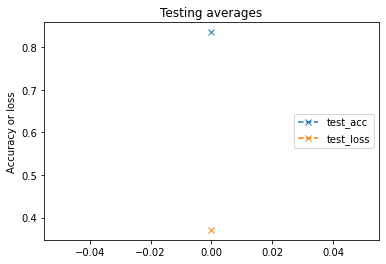

In [ ]:
 # Plot the average test accuracy and test loss for each parameter combination
 
 metrics = get_average(history, score)
fig = plt.figure(1)
#plt.xticks(np.r_[0:len(metrics['av_test_acc']):1])
plt.plot(metrics['test_acc'],'x--', label = 'test_acc')
plt.plot(metrics['test_loss'],'x--', label = 'test_loss')
plt.ylabel('Accuracy or loss')
plt.legend(loc='right')
plt.title('Testing averages')
# fig.savefig('/content/drive/My Drive/Processed data/lstm_acc_5_times.png')
for i in range (len(runs)):
  print('par comb '+str(i))
  print(runs[i])

print(metrics['av_test_acc'])
print(metrics['test_acc'])
print()

In [ ]:
# Train the network with the best hyperparameters and save the model
all_history, all_score, model_m = find_hyper_LSTM(x_t_c, x_t_a, x_test_c, x_test_a, ytrain, ytest, hyper_lstm)

val_acc = round(all_score[0][1], 2)

#model = load_model('my_model.h5')

Training network 0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Create the correct input arrays for the LSTM network

TIME_PERIODS = x_t_c.shape[1]
num_features = 2
number_samples = x_t_c.shape[0]
number_test = x_test_c.shape[0]

x_train = np.zeros((number_samples, TIME_PERIODS, num_features))
x_test = np.zeros((number_test, TIME_PERIODS, num_features))

x_train[:,:,0] = x_t_a
x_train[:,:,1] = x_t_c
x_test[:,:,0] = x_test_a
x_test[:,:,1] = x_test_c

0
Run(Batch_size=32, layers=1, LongShort=100)
[0.61448139 0.66012204]


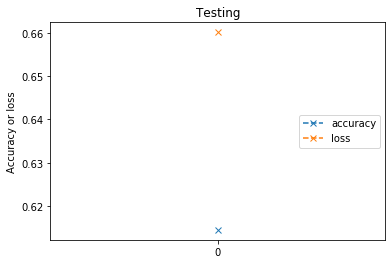

In [ ]:
# Plots the test accuracy and test loss for all combinations

scores = np.zeros((len(all_score),2))

for i in range (len(all_score)):
  scores[i,0] = all_score[i][1] # accuracy
  scores[i,1] = all_score[i][0] # loss

plt.xticks(np.r_[0:len(all_score):1])
plt.plot(np.r_[0:len(all_score):1], scores[:,0],'x--', label = 'accuracy')
plt.plot(np.r_[0:len(all_score):1], scores[:,1],'x--', label = 'loss')
plt.ylabel('Accuracy or loss')
plt.legend(loc='right')
plt.title('Testing')

# n = 3
for n in range (0, len(all_score)):
  print(n)
  print(runs[n])
  print(scores[n,:])